In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [51]:
### Load the Model

In [2]:
# First Load VGG16 model to extract the features from the image
model  = VGG16()
# restructure the model
model =  Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [3]:
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# extract the features from image
features={}
directory = os.path.join('.//Dataset//Images')

for img_name in tqdm(os.listdir(directory)):
    
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data from model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for vgg
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image ID
    image_id = img_name.split('.')[0]
    
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# Store features in pickle
pickle.dump(features, open(os.path.join('./','features.pkl'),'wb'))


In [6]:
# load features from pickle
with open(os.path.join('./','features.pkl'),'rb') as f:
    features = pickle.load(f)            

In [7]:
# Load the Captions 
with open(os.path.join('.//Dataset','captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    token = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = token[0], token[1:]
    
    # remove extension from imageID
    image_id = image_id.split('.')[0]
    
    # convert caption list to string
    caption = " ".join(caption)
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #store the multiple captions for single image using append()
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

In [11]:
# PREPROCESS TEXT DATA - 

# preprocessing function
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            
            # preprocessing steps
            
            # converting into lower case
            caption = caption.lower()
            # removing all special character and digits except alphabets
            caption = caption.replace('[^A-Za-z]','')
            # removing additional spaces 
            caption = caption.replace('\s+',' ')
            # Add start and end tags to the caption
            # and we ignore the single length alphabet like, A..,
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
            
# Doing Preprocessing of text by calling clean() function.
clean(mapping)          

In [12]:
mapping['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

In [13]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
# tokenizer the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [18]:
# TRAIN TEST SPLIT - 

# for retrieveing data very effectively, we split it into different parts so that normal system can also run efficiently

# total image ids for training
image_ids = list(mapping.keys())
# spliting those data as 90% for training
split = int(len(image_ids) * 0.90)
# putting 90% image ids into the separate train object 
train = image_ids[:split]
# putting remaining 10% image ids into the separate test object
test = image_ids[split:]

In [19]:
# EXPLAINING, HOW SEQUENCE IS GETTING SPLITTED
#Ex., sequence for --> <start>little girl is sitting in front of large painted rainbow<end>

#                  X                                                          y

# startseq                                                                   little
# startseq little                                                            girl
# startseq little girl                                                       is
# startseq little girl is                                                    sitting
# ...................                                                       .....
# startseq little girl is sitting in front of large painted rainbow         endseq

# like this, one by one word is getting into X upto the endseq

In [20]:
# create DataGenerator function in order to fetch the image and caption in "batch"(avoid session crash)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1,X2,y = list(),list(),list()
    n = 0
    while 1:
        # data_keys - image_ids from the training data
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0  
            

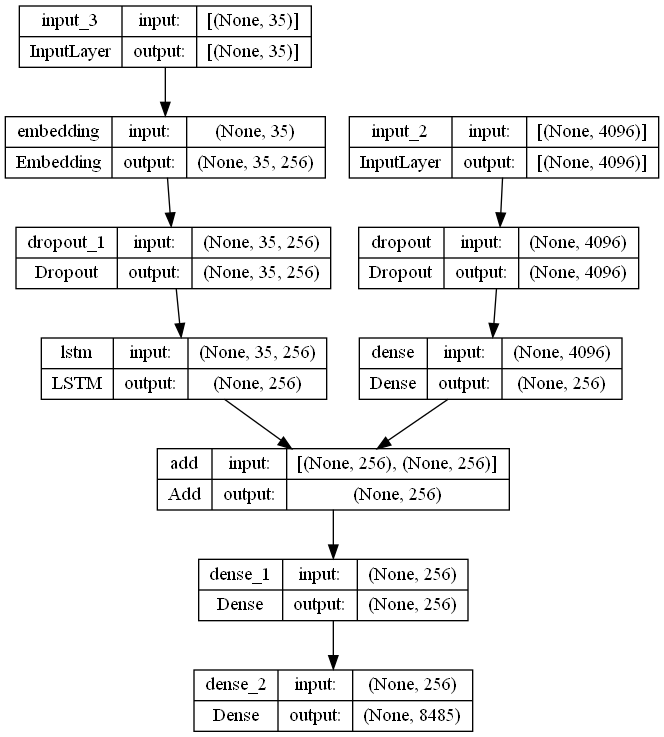

In [21]:
# MODEL CREATION - 

# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs= outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes = True)

In [22]:
# TRAIN THE MODEL

epochs = 15 # if increases, output score also increases
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # fit for one epoch
    model.fit(generator, epochs = 1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 513s 5s/step - loss: 2.4839


In [23]:
# save the model
model.save('./best_model.h5') 

In [24]:
# GENERATE CAPTIONS FOR THE IMAGE


def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None    

In [34]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequence
        sequence = pad_sequences([sequence],max_length)
        
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # get index with hig probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # stop if word not found
        if word is None:
            break
        
        # append word as input for generating next word
        in_text += " " + word
        
        # stop if we reach end tag
        if word == 'endseq':
            break
        
    return in_text

In [46]:
# VALIDATE WITH TEST DATA

from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
# calculate BLEU score
print("BLEU-1 : %f"% corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2 : %f"% corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 : 0.540082
BLEU-2 : 0.318142


# VISUALIZE THE RESULTS

In [47]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(".\\Dataset","Images",image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]

    print('------------------ACTUAL-------------------')

    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    print('------------------PREDICTED-------------------')
    print(y_pred)
    plt.imshow(image)

------------------ACTUAL-------------------
startseq boy descends off the end of high diving board endseq
startseq child jumps off high diving board into the pool endseq
startseq kid jumps off the diving board and into the swimming pool below endseq
startseq little kid is jumping off high dive at the pool endseq
startseq the boy is jumping off high diving board into the pool endseq
------------------PREDICTED-------------------
startseq boy jumps off diving board into pool endseq


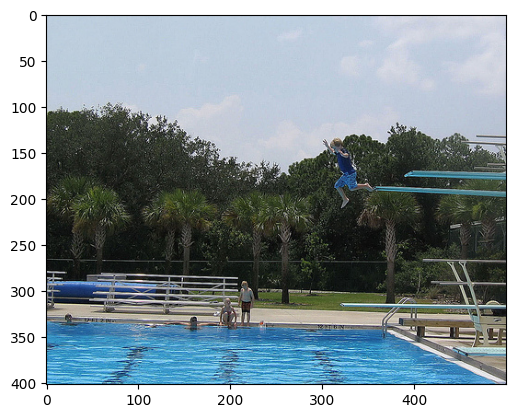

In [50]:
generate_caption("1057089366_ca83da0877.jpg")